<a href="https://colab.research.google.com/github/carlosbarrone/public_notebooks/blob/main/movie_genre_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re

from sklearn.model_selection import train_test_split

from keras.models import Sequential

from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, GlobalMaxPool1D, Dropout, Bidirectional, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project Introduction

This project is about predicting the genres of a movie from a given title and synopsis. I will primarily use a deep learning approach to solving this challenge and use techniques like word embedding, natural language processing.

# Data Source
The dataset I will use to train and test my model can be found in here:
https://www.kaggle.com/datasets/dk123891/10000-movies-data

It contains the information of IMDb's top 10,000 rated movies, and it was scraped from the website.

Here is a sample:

In [26]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/IMDB_10000_MOVIES'
df = pd.read_csv(f'{data_path}/data.csv')
df.sample(2)

,Unnamed: 0,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
2680,2680,The Professionals,1966,117,7.3,18192,75.0,19540000.0,"['Action', ' Adventure', ' Drama']",PG-13,['Richard Brooks'],"['Burt Lancaster', 'Lee Marvin', 'Robert Ryan'...","['An', 'arrogant', 'Texas', 'millionaire', 'hi..."
9236,9236,Gabriel,2007,114,5.5,14178,NaN,NaN,"['Action', ' Fantasy', ' Horror']",R,['Shane Abbess'],"['Andy Whitfield', 'Dwaine Stevenson', 'Samant...","['Gabriel', 'the', 'archangel', 'fights', 'to'..."


# EDA

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           10000 non-null  int64  
 1   Movie Name           10000 non-null  object 
 2   Year of Release      10000 non-null  int64  
 3   Run Time in minutes  10000 non-null  int64  
 4   Movie Rating         10000 non-null  float64
 5   Votes                10000 non-null  int64  
 6   MetaScore            7974 non-null   float64
 7   Gross                7085 non-null   float64
 8   Genre                10000 non-null  object 
 9   Certification        9631 non-null   object 
 10  Director             10000 non-null  object 
 11  Stars                10000 non-null  object 
 12  Description          10000 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 1015.8+ KB


The dataset contains 10,000 rows, and 12 columns (+ Index), I will be focusing on the movie title, genre and description (synopsis).

The underlying data for each are strings, and the genre specifically is composed by lists of strings, since each movie can be labeled for more than one genre. This is very important to consider for the selection of the model, it's architecture, hyperparameters, metrics and loss calculation. This information can be found on later sections.

The class below build is used for EDA and preprocessing.

In [28]:
stopwords = stopwords.words('english')

def build_validation_graph(history, model_name: str = ''):
    metric_name = 'auc' if 'auc' in history.history else 'auc_1'
    val_name = 'val_auc' if 'val_auc' in history.history else 'val_auc_1'
    plt.plot(history.history[metric_name])
    plt.plot(history.history[val_name])
    plt.title(f'Model AUC {model_name}')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def build_encoder(df: pd.DataFrame, vocabulary_size: int, max_len: int):
    encoder = TextVectorization(
        max_tokens=vocabulary_size,
        output_mode='int',
        output_sequence_length=max_len
    )
    encoder.adapt(df.to_list())
    return encoder

def build_tokenizer(df: pd.DataFrame, vocabulary_size: int, max_len: int):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(df)
    sequences = tokenizer.texts_to_sequences(df)
    return pad_sequences(sequences, maxlen=max_len)

class Project_Data:
    def __init__(self, raw_df: pd.DataFrame, seed:int, use_stop_words: bool)->None:
        self.df = self.process_df(raw_df)
        self.all_genres = self.get_all_genres()
        self.df[self.all_genres] = self.df.genre.apply(lambda genres: np.isin(self.all_genres, genres)).to_list()
        self.df = self.df.drop(['genre'], axis=1).astype(
            {g:'int8' for g in self.all_genres}
        )
        self.df_text_metrics = pd.DataFrame({
            'text_length': self.df.text.str.len(),
            'num_words': self.df.text.str.split(' ').apply(len)
        })
        self.max_text_length = self.df.text.str.split(' ').apply(len).max()
        X = self.df['text']
        X_wsw = self.df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
        y = self.df.iloc[:,3:]
        if use_stop_words:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_wsw, y, test_size=0.05, random_state=seed)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.05, random_state=seed)

    def process_df(self, raw_df: pd.DataFrame):
        rgx = r'[^a-zA-Z0-9 ]+'
        df = raw_df.rename(columns={
            'Movie Name':'title',
            'Genre':'genre',
            'Description':'description',
        }).assign(
            title=lambda x: x.title.str.replace(rgx, '', regex=True).str.lower().str.strip(),
            synopsis=lambda x: x.description.str.replace(rgx, '', regex=True).str.lower().str.strip(),
            genre=lambda x: x.genre.str.replace(r'[^a-zA-Z0-9,]+', '', regex=True).str.split(',')
        ).assign(
            text=lambda x: x.title + ' ' + x.synopsis
        )[['title','synopsis','text','genre']]
        return df

    def get_all_genres(self):
        return list(set([g for l in self.df.genre.to_list() for g in l]))

    def preprocess_test_text(self, title:str, synopsis: str, remove_stop_words: bool):
        text = title + synopsis
        rgx = r'[^a-zA-Z0-9 ]+'
        text = re.sub(rgx, '', text)
        text = text.lower()
        text = text.strip()
        if remove_stop_words:
            text = ' '.join([w for w in text.split(' ') if w not in stopwords])
        return pd.Series([text])

    def get_prediction_genres(self, predictions, threshold):
        genres = []
        for (p, g) in zip(predictions[0], self.all_genres):
            if p>threshold:
                genres.append(g)
        return genres

In [29]:
project_data = Project_Data(df, seed=2023, use_stop_words=False)

# NLP and Word Embedding

Natural Language Processing (NLP) is an AI sub-field focused on translating speech between computers and human language. Its objective is to enable machines to comprehend, interpret, and produce text or speech.

Word embedding is the process of representing words as numerical vectors in a multidimensional space. It is essential for processing and understanding natural language in machine learning applications. Here are some of the most important concepts and parameters:

- Word Embedding: Technique that assigns vector representations to words in a text corpus. Very importantly, machine learning algorithms are not capable of processing words, so each word must be converted into vectors of numbers, and each vector captures the semantic and contextual relationships between words in the text corpus, making it easier to understand the meaning of words contextually.

- Dimension Space: The size of the vectors. A higher dimension can capture more complex relationships, will also be more computationally expensive.

- Window Context: The number of surrounding words that are considered when creating word embeddings. If larger, the long-term relationships are easier to capture, if smaller the context will focus on close relationships.

- Embedding Algorithm: Word2Vec, GloVe, FastText, etc. Each of these approaches uses different strategies to capture contextual and semantic information, I will use Tensorflow.

- Vocabulary Size: The effectiveness of word embeddings is significantly influenced by the scale and inclusiveness of the training dataset. A greater and more heterogeneous dataset yields superior word representations.

- Supervised vs. Unsupervised Training: During supervised training, supplementary text labels (e.g., POS or sentiment tags) can be incorporated to enhance the quality of the embeddings. In contrast, unsupervised training generates embeddings solely based on the text's structural properties.

- Fine-Tuning: Subsequent to the creation of word embeddings, they can often be customized for specific machine learning tasks, like text classification or translation.

In conclusion, word embeddings constitute a vital technique in natural language processing, converting words into numerical vectors to encapsulate their semantics and context. Fundamental parameters, including dimensionality, context window, and the choice of embedding algorithm, significantly affect the quality and applicability of these representations. These vectors hold a pivotal position in a wide array of machine learning applications related to natural language processing

Below, the distribution of the vocabulary size and the length of the synopsis, this will be important to adjust later for the model.

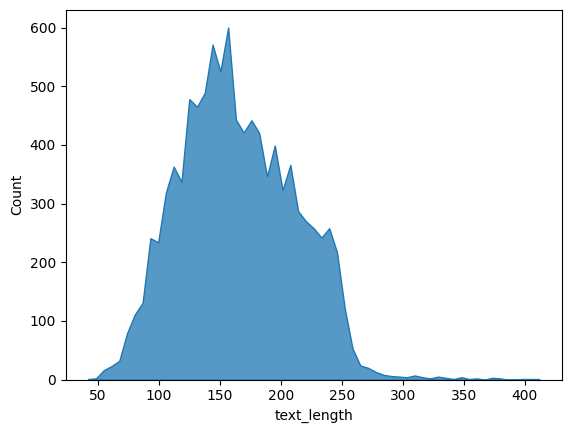

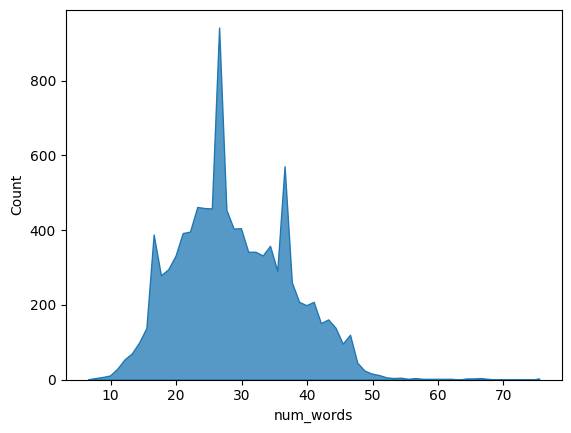

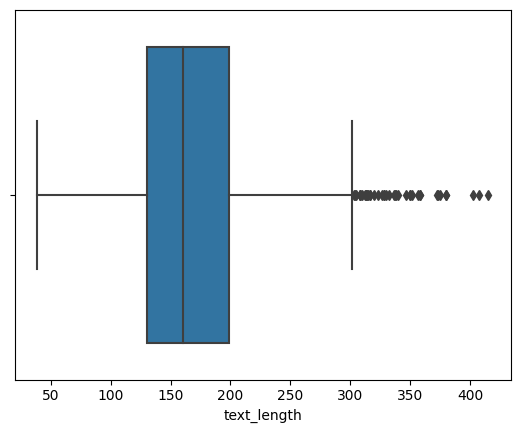

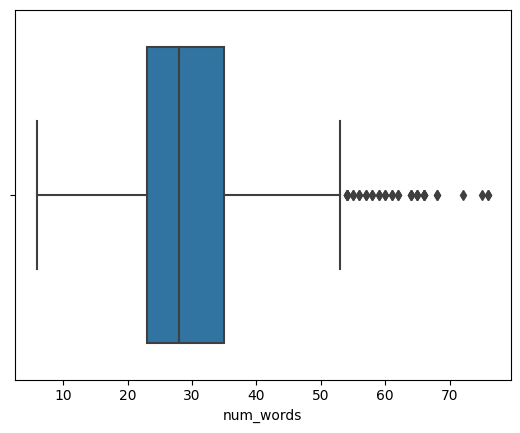

In [6]:
sns.histplot(data=project_data.df_text_metrics, x="text_length", element="poly")
plt.show()
sns.histplot(data=project_data.df_text_metrics, x="num_words", element="poly")
plt.show()
sns.boxplot(data=project_data.df_text_metrics, x="text_length")
plt.show()
sns.boxplot(data=project_data.df_text_metrics, x="num_words")
plt.show()

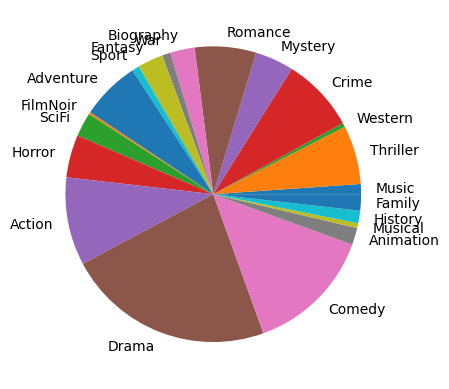

In [7]:
genre_count = project_data.y_train.sum()
counts, genres = genre_count.values, genre_count.index.values
plt.pie(counts, labels=genres)
plt.show()

We can see that the length of the synopsis text is centered in between 120-200 characters, with some outliers. The max text length will be important if we want to truncate the text by length, if we think some length x is enough for the model to capture the genres.

The number of words by text is centered in between 20 and 40 with some outliers, this will give us some input on what to choose for the vocabulary size.

Then we can also see the distribution of the genres in our dataset.

# Data Processing

In the Project Data class above we have the following data cleaning operations:
- Rename the columns and set as lower case
- From the text and title, remove anything that is not a letter, number or space
- Trim any empty spaces
- Set text as lower case
- From the genre, convert from string to list of strings
- Get a list of all the genres present in the dataset
- Separate and one hot encode each genre as 1 or 0 as separate columns (This will compose the label data frame
- Separate training and testing datasets, there will be an additional split, for validation within the tensorflow model.
- Create the X_train dataframe with or wothout stopwords, we will compare the results from both

# Analysis, Model Selection and Architecture

Since we will be processing text, I will attempt to use a Bidirectional LSTM model, but first I will use a regular neural network to have a benchmark.

In [6]:
total_genres = len(project_data.all_genres)
vocab_size, max_len, output_dims, model_output_dims = 450, 160, 55, total_genres
X_tokenized = build_tokenizer(df=project_data.X_train, vocabulary_size=vocab_size, max_len=max_len)
X_tokenized_test = build_tokenizer(df=project_data.X_test, vocabulary_size=vocab_size, max_len=max_len)

For this model I will build an embedding layer, maxpool layer, and a final layer with 21 neurons, since the total number of genres is 21.

In [9]:
model_output_dims = len(project_data.all_genres)
gpus = tf.config.list_logical_devices('GPU')
print("Number of available GPUs: ", len(gpus))
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = Sequential()
    model.add(Embedding(vocab_size, output_dims, input_length=max_len))
    model.add(GlobalMaxPool1D())
    model.add(Dense(model_output_dims, activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Number of available GPUs:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 55)           24750     
                                                                 
 global_max_pooling1d (Glob  (None, 55)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 21)                1176      
                                                                 
Total params: 25926 (101.27 KB)
Trainable params: 25926 (101.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I played around with the vocabalury size, max length of the text (truncating the text), the vector size. In order not to underfit I used the adam optimizer with the standard learning rate and some callbacks to adjust the learning rate and implementing early stopping, with different parameters:
- Patience set to 6 epochs
- Restore best weights to get the best overall results
- A factor of 0.1 to decrease learning rate
- Patience of 2 epochs for the learning rate adjustment to kick in
- A very small learning rate min
- Total Epochs = 50

In [10]:
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000000001)
history = model.fit(
    X_tokenized,
    project_data.y_train,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks =[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
238/238 [==============================] - 18s 55ms/step - loss: 0.4470 - auc: 0.6488 - val_loss: 0.3081 - val_auc: 0.7998 - lr: 0.0010
Epoch 2/50
238/238 [==============================] - 3s 14ms/step - loss: 0.3009 - auc: 0.8059 - val_loss: 0.2989 - val_auc: 0.8119 - lr: 0.0010
Epoch 3/50
238/238 [==============================] - 2s 8ms/step - loss: 0.2965 - auc: 0.8140 - val_loss: 0.2958 - val_auc: 0.8166 - lr: 0.0010
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.2934 - auc: 0.8188 - val_loss: 0.2932 - val_auc: 0.8201 - lr: 0.0010
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 0.2907 - auc: 0.8230 - val_loss: 0.2909 - val_auc: 0.8240 - lr: 0.0010
Epoch 6/50
238/238 [==============================] - 3s 11ms/step - loss: 0.2883 - auc: 0.8268 - val_loss: 0.2895 - val_auc: 0.8266 - lr: 0.0010
Epoch 7/50
238/238 [==============================] - 2s 8ms/step - loss: 0.2859 - auc: 0.8306 - val_loss: 0.2873 - val_auc:

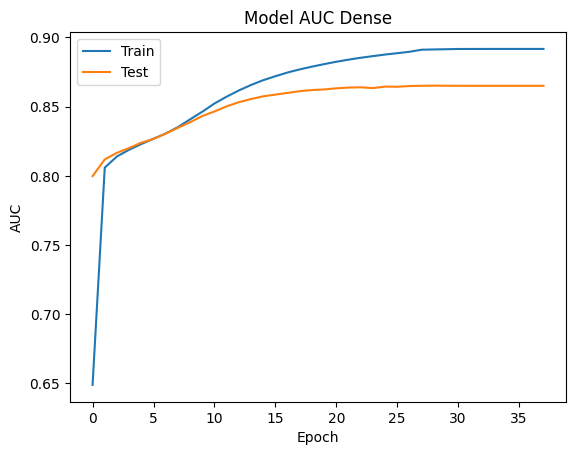

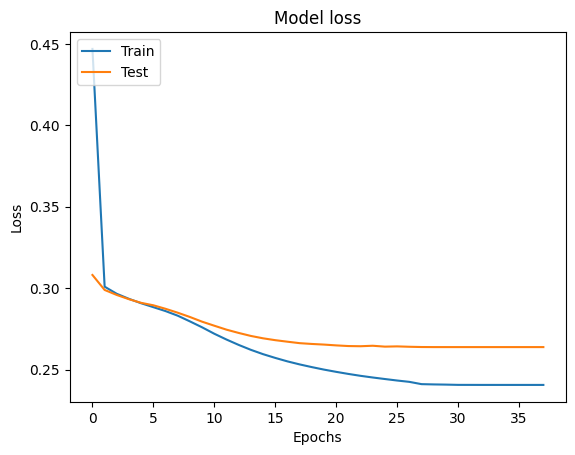

In [11]:
build_validation_graph(history=history, model_name='Dense')

In [12]:
results = model.evaluate(X_tokenized_test, project_data.y_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.3169 - auc: 0.7995


# Bidirectional LSTM

For the second model I will build a Bidirectional LSTM model.
This time I will use a Tensorflow encoder, instead of the vectorizer.

The parameters I will use will be similar:
I also played around with the vocabalury size, max length of the text (truncating the text), the vector size. In order not to underfit I used the adam optimizer with the standard learning rate and some callbacks to adjust the learning rate and implementing early stopping, with different parameters:
- Patience set to 6 epochs
- Restore best weights to get the best overall results
- A factor of 0.1 to decrease learning rate
- Patience of 2 epochs for the learning rate adjustment to kick in
- A very small learning rate min
- Total Epochs = 50

I believe the bidirectional LSTM will be better suited for NLP, because it is optimized for taking the context of the text into account.

At the beginning I started working with the accuracy for the metrics and this was obviously wrong and didn't work. I switched to AUC, and then everything started to make sense. Another important thing to play around with is the removal of the stop words. I thought the model would behave very differently, but that's not the case. Finally I selected the Bidirectional LSTM model, with stop word removal this can be switched on/off with the Project Data Class implementation parameter.

In [7]:
#gpus.clear()
optimizer = Adam(learning_rate=0.001)
X_train, y_train, X_test, y_test = project_data.X_train, project_data.y_train, project_data.X_test, project_data.y_test
encoder_lstm = build_encoder(X_train, vocab_size, max_len)

In [10]:
model_output_dims = len(project_data.all_genres)
#gpus = tf.config.list_logical_devices('GPU')
#print("Number of available GPUs: ", len(gpus))
#strategy = tf.distribute.MirroredStrategy(gpus)
#with strategy.scope():
if True:
    model_lstm = Sequential()
    model_lstm.add(encoder_lstm)
    model_lstm.add(Embedding(vocab_size, output_dims, input_length=max_len))
    model_lstm.add(Bidirectional(LSTM(max_len, return_sequences=False)))
    model_lstm.add(Dense(model_output_dims, activation='sigmoid'))
    model_lstm.compile(loss = 'binary_crossentropy', optimizer = optimizer , metrics = [tf.keras.metrics.AUC()])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 160)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 160, 55)           24750     
                                                                 
 bidirectional_1 (Bidirecti  (None, 320)               276480    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 21)                6741      
                                                                 
Total params: 307971 (1.17 MB)
Trainable params: 307971 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000000001)
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks =[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
238/238 [==============================] - 22s 71ms/step - loss: 0.3142 - auc_1: 0.7885 - val_loss: 0.3020 - val_auc_1: 0.8053 - lr: 0.0010
Epoch 2/50
238/238 [==============================] - 5s 23ms/step - loss: 0.3007 - auc_1: 0.8059 - val_loss: 0.3004 - val_auc_1: 0.8083 - lr: 0.0010
Epoch 3/50
238/238 [==============================] - 6s 24ms/step - loss: 0.2956 - auc_1: 0.8151 - val_loss: 0.2879 - val_auc_1: 0.8309 - lr: 0.0010
Epoch 4/50
238/238 [==============================] - 6s 25ms/step - loss: 0.2758 - auc_1: 0.8461 - val_loss: 0.2736 - val_auc_1: 0.8515 - lr: 0.0010
Epoch 5/50
238/238 [==============================] - 5s 19ms/step - loss: 0.2641 - auc_1: 0.8625 - val_loss: 0.2687 - val_auc_1: 0.8600 - lr: 0.0010
Epoch 6/50
238/238 [==============================] - 5s 22ms/step - loss: 0.2540 - auc_1: 0.8753 - val_loss: 0.2640 - val_auc_1: 0.8647 - lr: 0.0010
Epoch 7/50
238/238 [==============================] - 5s 22ms/step - loss: 0.2478 - auc_1: 0.8826 -

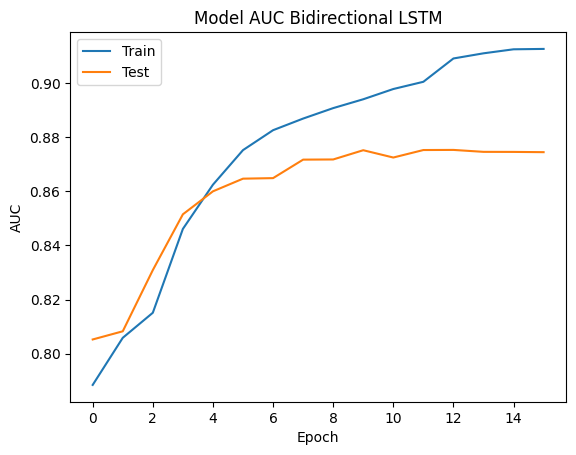

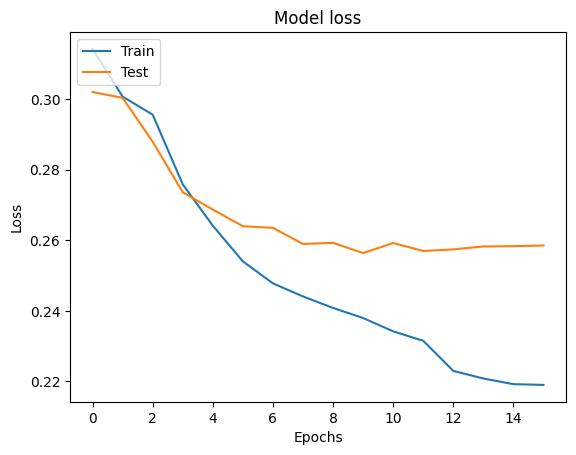

16/16 [==============================] - 0s 14ms/step - loss: 0.2464 - auc_1: 0.8870


In [30]:
build_validation_graph(history=history, model_name='Bidirectional LSTM')
results = model_lstm.evaluate(X_test, y_test)

# Results and Conclusion

I got a final AUC score of about 89% which is not perfect but it gives interesting results, I believe a bigger and better balanced dataset, would make the model more robust, but it's good as a start.

The biggest takeaways would be having a good selection of vocabulary size, good starting learning rate, and selecting the correct metrics for the loss function.

Finally here are some interesting predictions from fake movies generated by ChatGPT, upcoming movies, and classics, since there are not much Music datapoints in the dataset, I included 2, which are not predicted correctly, probably because of the class imbalance also, it was weird that the horror movies were very incorrectly classified as comedy!

In [13]:
# 10 FAKE MOVIE TITLES AND SYNOPSIS GENERATED BY CHATGPT
movie_1 = ("The Quantum Paradox", "In a world where time and space collide, a brilliant physicist must race against the clock to save humanity from a cataclysmic event.")
movie_2 = ("Galactic Guardians of Pizza", "A group of intergalactic pizza delivery drivers find themselves in the middle of an alien war, armed with nothing but pepperoni and mozzarella.")
movie_3 = ("The Secret Life of Teacups", "A whimsical tale where teacups come to life at night, embarking on epic adventures in a quest to find the fabled 'Handle of Destiny'.")
movie_4 = ("Zombie Prom Night", "When the undead rise on prom night, a group of high school students must slow dance, dodge zombies, and try to survive until sunrise.")
movie_5 = ("The Time-Traveling Barber", "A barber discovers that his vintage barber chair is a time machine, and he unintentionally changes history one bad haircut at a time.")
movie_6 = ("The Singing Spatula", "An animated musical adventure featuring a spatula that can sing, cook, and save the day when an evil chef threatens the culinary world.")
movie_7 = ("Penguins of the Caribbean", "A group of swashbuckling penguins sets sail on the high seas, seeking treasure, battling sea monsters, and stealing fish from pirates.")
movie_8 = ("The Quantum Corgi", "A lovable corgi gains the power of quantum teleportation, leading to hilarious escapades as he tries to chase squirrels across dimensions.")
movie_9 = ("Invisible Detective", "A detective gains the power of invisibility and uses it to solve crimes, but he soon discovers that being unseen comes with unexpected consequences.")
movie_10 = ("Attack of the Killer Garden Gnomes", "When garden gnomes come to life and wreak havoc on a suburban neighborhood, a group of unlikely heroes must defend their lawns.")

# IMDB Upcoming releases
movie_11 = ("The Mission","26-year-old American missionary John Chau was killed as he attempted to make contact with an Indigenous group off the coast of India, one of the last communities on the planet still living in isolation.") # Tagged as Documentary
movie_12 = ("Bhagwan Bharose","A story about two young, impressionable kids whose ideas about faith are constantly questioned and changed as their little world expands and takes into its fold, their country's fast-changing socio-political landscape.") # Tagged as Comedy, Drama
movie_13 = ("Killers of the Flower Moon","Members of the Osage tribe in the United States are murdered under mysterious circumstances in the 1920s, sparking a major F.B.I. investigation involving J. Edgar Hoover.") # Tagged as Crime, Drama, History
movie_14 = ("The Other Zoey","Zoey Miller, a super smart computer nerd who is uninterested in romantic love, has her life turned upside down when Zack, the school's soccer star, gets amnesia and mistakes Zoey for his girlfriend.") # Tagged as Comedy, Drama, Romance
movie_15 = ("The Canterville Ghost","An American family moves in to Canterville Chase, a stately countryside mansion that has been haunted by the ghost Sir Simon De Canterville for 300 years.") # Tagged as Animation, Comedy
movie_16 = ("Malibu Horror Story","Terror strikes when a team of paranormal investigators search a sacred cave for clues in the unsolved disappearance of four Malibu teens.") # Tagged as Horror, Thriller
movie_17 = ("Hayride to Hell","A small town farmer exacts his bloody revenge on unscrupulous town folk who try to steal his land.") # Tagged as Horror
# Dune?
movie_18 = ("Dune", "Paul Atreides, a brilliant and gifted young man born into a great destiny beyond his understanding, must travel to the most dangerous planet in the universe to ensure the future of his family and his people. As malevolent forces explode into conflict over the planet\'s exclusive supply of the most precious resource in existence, only those who can conquer their own fear will survive.")

movie_19 = ("In the Court of the Crimson King: King Crimson at 50","What began as a straightforward documentary about the cult rock band King Crimson as it turned 50, mutated into an exploration of time, death, family, and the transcendent power of music to change lives. But with jokes.")
movie_20 = ("Rush: Snakes & Arrows - Live in Holland","Filmed over two performances in Rotterdam, Holland in October of 2007, Rush's new program Snakes & Arrows Live captures the legendary band in peak form, performing classic Rush material and nine new songs from their critically acclaimed 2007 program Snakes & Arrows. This program includes bonus footage from their 2008 American tour, including \"Ghost of a Chance,\" filmed here for the first time.")
movies = [movie_1, movie_2, movie_3, movie_4, movie_5, movie_6, movie_7, movie_8, movie_9, movie_10, movie_11,movie_12,movie_13,movie_14,movie_15,movie_16,movie_17, movie_18, movie_19, movie_20]

for (title, synopsis) in movies:
    print(f'Title: {title}')
    print(f'Synopsis: {synopsis}')
    text = project_data.preprocess_test_text(title, synopsis, True)
    prediction = model_lstm.predict(text, verbose=0)
    genres = project_data.get_prediction_genres(prediction, 0.4)
    print(f'Genres: {genres}')
    print('\n')


Title: The Quantum Paradox
Synopsis: In a world where time and space collide, a brilliant physicist must race against the clock to save humanity from a cataclysmic event.
Genres: ['Animation', 'Comedy', 'Action', 'Adventure']


Title: Galactic Guardians of Pizza
Synopsis: A group of intergalactic pizza delivery drivers find themselves in the middle of an alien war, armed with nothing but pepperoni and mozzarella.
Genres: ['Action']


Title: The Secret Life of Teacups
Synopsis: A whimsical tale where teacups come to life at night, embarking on epic adventures in a quest to find the fabled 'Handle of Destiny'.
Genres: ['Drama', 'Comedy']


Title: Zombie Prom Night
Synopsis: When the undead rise on prom night, a group of high school students must slow dance, dodge zombies, and try to survive until sunrise.
Genres: ['Drama', 'Comedy']


Title: The Time-Traveling Barber
Synopsis: A barber discovers that his vintage barber chair is a time machine, and he unintentionally changes history one b